In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter, defaultdict
import os 
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch
from tqdm import tqdm
import tensorflow as tf

In [2]:
min_count=4

In [3]:
class ImageLabelDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None, split="train", seed=42):
        """
        Args:
            images_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les informations.
            transform (callable, optional): Transformations à appliquer aux images.
            split (string): "train", "val" ou "test" pour choisir le dataset.
            seed (int): Pour rendre la répartition fixe.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        
        self.data = pd.read_csv(csv_file)
        self.boxes = self._create_boxes_list()

        self.class_counts = self.count_classes()

    def _create_boxes_list(self):
        """
        Crée une liste de dictionnaires où chaque boîte est une entrée unique.
        """
        boxes = []
        for _, row in self.data.iterrows():
            image_id = str(row['id'])
            bbox = [row['xc'], row['yc'], row['w'], row['h']]
            avis = row['avis']
            label = self.avis_majoritaire(avis)
            if label in [None]:  
                boxes.append({
                    'image_id': image_id,
                    'bbox': bbox,
                    'avis': avis,
                    'xc': row['xc'],
                    'yc': row['yc'],
                    'w': row['w'],
                    'h': row['h']
                })
        return boxes


    def count_classes(self):
        """
        Compte le nombre d'instances pour chaque classe dans le dataset actuel.
        """
        class_counts = defaultdict(int)
        for annotation in self.boxes:
            avis = annotation['avis']
            class_counts[avis] += 1
        return dict(class_counts)


    def avis_majoritaire(self, avis, min_count=4):
        """Calcule l'avis majoritaire uniquement s'il dépasse un seuil minimal."""
        parts = avis.split('_')
        count = Counter(parts)
        
        majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
        
        if occurrences >= min_count:
            return int(majoritaire)
        
        return None


    def __len__(self):
        return len(self.boxes)


    def __getitem__(self, idx):
        """
        Retourne une image découpée selon la boîte englobante et son label.
        """
        annotation = self.boxes[idx]
        bbox = annotation['bbox']
        avis = annotation['avis']

        image_path = os.path.join(self.images_dir, f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")

        xc, yc, w, h = bbox
        x_min = int((xc - w / 2) * image.width)
        x_max = int((xc + w / 2) * image.width)
        y_min = int((yc - h / 2) * image.height)
        y_max = int((yc + h / 2) * image.height)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            cropped_image = self.transform(cropped_image)
            
        # label = torch.tensor(label, dtype=torch.long)
            
        return cropped_image, avis, annotation['image_id'], annotation['xc'], annotation['yc'], annotation['w'], annotation['h']

In [4]:
img_dir = "./../data"
csv_file = "./../info_data.csv"

num_classes = 9
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset

#### Matis Axel

In [9]:
transform_axel = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    ])

image_no_label_axel = ImageLabelDataset(images_dir=img_dir, csv_file=csv_file, transform=transform_axel)
test_loader_axel = DataLoader(image_no_label_axel, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
transform_matis = transforms.Compose([
    transforms.Resize((512, 512), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8032728433609009, 0.7945748567581177, 0.7861791253089905], std=[0.14696455001831055, 0.1625434011220932, 0.15391086041927338])
    ])

image_no_label_matis = ImageLabelDataset(images_dir=img_dir, csv_file=csv_file, transform=transform_matis)
test_loader_matis = DataLoader(image_no_label_matis, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


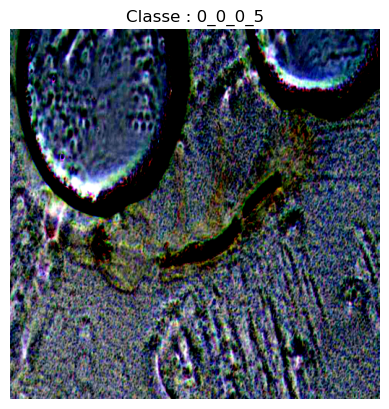

In [6]:
image, label, img_id, _, _, _,_ = image_no_label_matis[10]
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Classe : {label}")
plt.axis('off')
plt.show()

## Model Axel

In [8]:
model_axel = None
model_axel = models.vit_b_16(pretrained=True)

model_axel.heads.head = nn.Linear(model_axel.heads.head.in_features, num_classes)
model_axel.to(DEVICE)
model_axel.load_state_dict(torch.load(f'./../model_axel/VITAXEL_NET__8BATCH_0.0001LR_50EPOCH_224SIZE.pth'))
model_axel.eval()

c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Model Matis

In [7]:
model_matis = None
model_matis = models.efficientnet_b0(pretrained=True)
for param in model_matis.parameters():
    param.requires_grad = False
in_features = model_matis.classifier[1].in_features

model_matis.classifier = nn.Sequential(
    nn.Linear(in_features, 128),          # Première couche linéaire avec 512 unités
    nn.BatchNorm1d(128),                  # Batch Normalization après la couche linéaire
    nn.PReLU(),                           # Fonction d'activation ReLU
    nn.Linear(128, num_classes)          # Dernière couche linéaire pour les classes finales
)
model_matis.to(DEVICE)
model_matis.load_state_dict(torch.load(f'./../model/EfficientNet_data4_norm_8BATCH_0.001LR_40EPOCH_512SIZE.pth'))
model_matis.eval()

c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mbrei\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Inférence

In [10]:
import csv
import torch.nn.functional as F

results = []
model_axel.eval()
model_matis.eval()

with torch.no_grad():
    for (img_axel, avis, image_id, xc, yc, w, h), (img_matis, _, _, _, _, _,_) in zip(test_loader_axel, test_loader_matis):

        img_axel = img_axel.to(DEVICE)
        img_matis = img_matis.to(DEVICE)

        outputs_axel = model_axel(img_axel)
        outputs_matis = model_matis(img_matis)

        probas_axel = F.softmax(outputs_axel, dim=1)
        probas_matis = F.softmax(outputs_matis, dim=1)

        for i in range(len(img_axel)):
            avis_img = avis[i]
            image_name = image_id[i]
            bbox_img = [xc[i].item(), yc[i].item(), w[i].item(), h[i].item()]

            predict_matis = probas_matis[i].tolist()
            predict_axel = probas_axel[i].tolist()

            results.append([image_name, bbox_img, avis_img, predict_axel, predict_matis])

# Sauvegarde des résultats
csv_output_path = './image_sans_label_axel_matis.csv'
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['idx', 'bbox', 'avis', 'predict_axel', 'predict_matis'])
    writer.writerows(results)

print(f"Fichier CSV de soumission sauvegardé sous {csv_output_path}")


Fichier CSV de soumission sauvegardé sous ./image_sans_label_axel_matis.csv


## Choix du label avec probas

In [86]:
import ast
# label_ivan = pd.read_csv('./image_label_logits_inferred.csv')
label_axel = pd.read_csv('./image_sans_label_axel_matis.csv')[['idx', 'bbox', 'avis', 'predict_axel']]
label_matis = pd.read_csv('./image_sans_label_axel_matis.csv')[['idx', 'bbox', 'avis', 'predict_matis']]
label_mehdi = pd.read_csv('./predictions_cnn_xgb_logit_nolabel.csv')
label_ivan = pd.read_csv('./predictions_cnn_vit_logit.csv')


label_mehdi['bbox'] = label_mehdi.apply(lambda row: [row['xc'], row['yc'], row['w'], row['h']], axis=1)
label_mehdi['bbox'] = label_mehdi['bbox'].apply(lambda bbox: tuple(round(val, 5) for val in bbox))
label_mehdi.rename(columns={'image_id': 'idx'}, inplace=True)

label_ivan['bbox'] = label_ivan.apply(lambda row: [row['x_center'], row['y_center'], row['width'], row['height']], axis=1)
label_ivan['bbox'] = label_ivan['bbox'].apply(lambda bbox: tuple(round(val, 5) for val in bbox))
label_ivan.rename(columns={'image_name': 'idx'}, inplace=True)

label_matis['bbox'] = label_matis['bbox'].apply(lambda x: tuple(ast.literal_eval(x)) if isinstance(x, str) else x)
label_matis['bbox'] = label_matis['bbox'].apply(lambda bbox: tuple(round(val, 5) for val in bbox))

label_axel['bbox'] = label_axel['bbox'].apply(lambda x: tuple(ast.literal_eval(x)) if isinstance(x, str) else x)
label_axel['bbox'] = label_axel['bbox'].apply(lambda bbox: tuple(round(val, 5) for val in bbox))

In [87]:
label_axel['predict_axel'] = label_axel['predict_axel'].apply(eval)
columns = [f'logit_class_{i}' for i in range(9)]
axel_expanded = pd.DataFrame(label_axel['predict_axel'].tolist(), columns=columns)
label_axel = pd.concat([label_axel, axel_expanded], axis=1)

label_matis['predict_matis'] = label_matis['predict_matis'].apply(eval)
columns = [f'logit_class_{i}' for i in range(9)]
matis_expanded = pd.DataFrame(label_matis['predict_matis'].tolist(), columns=columns)
label_matis = pd.concat([label_matis, matis_expanded], axis=1)

In [88]:
label_mehdi["avis"] = label_mehdi["avis"].astype(str).str.replace("b'", "").str.replace("'", "")

In [89]:
label_ivan = label_ivan.merge(label_mehdi[['idx','bbox','avis']], on=["idx", "bbox"], how="left")

In [90]:
label_ivan.head(2)

,idx,x_center,y_center,width,height,logit_class_0,logit_class_1,logit_class_2,logit_class_3,logit_class_4,logit_class_5,logit_class_6,logit_class_7,logit_class_8,bbox,avis
0,0.227249003819710140.78286216702899760.3175101...,0.157878,0.650391,0.187500,0.531250,0.691265,0.003518,0.004518,0.002933,0.248031,0.004586,0.002992,0.040062,0.002097,"(0.15788, 0.65039, 0.1875, 0.53125)",0_2_0_4
1,0.62959327540824830.064861203841840580.5070058...,0.101562,0.530029,0.159505,0.402832,0.984490,0.000102,0.001081,0.000032,0.000275,0.013672,0.000052,0.000207,0.000090,"(0.10156, 0.53003, 0.15951, 0.40283)",7_2_2_2


In [91]:
def adjust_logits(row):
    avis_list = list(map(int, row["avis"].split("_")))  # Convertir l'avis en liste de chiffres

    poids = 1 / 9  

    for val in avis_list:
        col_name = f"logit_class_{val}"
        if col_name in row:
            row[col_name] += poids 
    
    return row

label_axel_avis = label_axel.apply(adjust_logits, axis=1)
label_mehdi_avis = label_mehdi.apply(adjust_logits, axis=1)
label_matis_avis = label_matis.apply(adjust_logits, axis=1)
label_ivan_avis = label_ivan.apply(adjust_logits, axis=1)

In [92]:
label_ivan_avis.head(2)

,idx,x_center,y_center,width,height,logit_class_0,logit_class_1,logit_class_2,logit_class_3,logit_class_4,logit_class_5,logit_class_6,logit_class_7,logit_class_8,bbox,avis
0,0.227249003819710140.78286216702899760.3175101...,0.157878,0.650391,0.187500,0.531250,0.913488,0.003518,0.115629,0.002933,0.359142,0.004586,0.002992,0.040062,0.002097,"(0.15788, 0.65039, 0.1875, 0.53125)",0_2_0_4
1,0.62959327540824830.064861203841840580.5070058...,0.101562,0.530029,0.159505,0.402832,0.984490,0.000102,0.334414,0.000032,0.000275,0.013672,0.000052,0.111318,0.000090,"(0.10156, 0.53003, 0.15951, 0.40283)",7_2_2_2


### Add f1 score

In [93]:
f1_scores = {
    "axel": {
        '0': 0.7665,
        '1': 0.8449,
        '2': 0.6923,
        '3': 0.8916,
        '4': 0.5667,
        '5': 0.8393,
        '6': 0.8506,
        '7': 0.6136,
        '8': 0.9640
    },
    'mehdi': {
        '0': 0.78,
        '1': 0.89,
        '2': 0.71,
        '3': 0.92,
        '4': 0.57,
        '5': 0.76,
        '6': 0.94,
        '7': 0.70,
        '8': 0.93
    },
    'matis': {
        '0': 0.7459,
        '1': 0.8681,
        '2': 0.7800,
        '3': 0.7561,
        '4': 0.6769,
        '5': 0.7967,
        '6': 0.9195,
        '7': 0.6296,
        '8': 0.9241
    },
    'ivan': {
        '0': 0.76,
        '1': 0.93,
        '2': 0.77,
        '3': 0.90,
        '4': 0.69,
        '5': 0.83,
        '6': 0.93,
        '7': 0.72,
        '8': 1.00
    },
}         

In [94]:
for class_idx, factor in f1_scores.get('mehdi', {}).items():
    column_name = f"logit_class_{class_idx}"
    if column_name in label_mehdi_avis.columns:
        label_mehdi_avis[column_name] *= factor
        
for class_idx, factor in f1_scores.get('axel', {}).items():
    column_name = f"logit_class_{class_idx}"
    if column_name in label_axel_avis.columns:
        label_axel_avis[column_name] *= factor
        
for class_idx, factor in f1_scores.get('matis', {}).items():
    column_name = f"logit_class_{class_idx}"
    if column_name in label_matis_avis.columns:
        label_matis_avis[column_name] *= factor
        
for class_idx, factor in f1_scores.get('ivan', {}).items():
    column_name = f"logit_class_{class_idx}"
    if column_name in label_ivan_avis.columns:
        label_ivan_avis[column_name] *= factor

In [95]:
label_ivan_avis.head(2)

,idx,x_center,y_center,width,height,logit_class_0,logit_class_1,logit_class_2,logit_class_3,logit_class_4,logit_class_5,logit_class_6,logit_class_7,logit_class_8,bbox,avis
0,0.227249003819710140.78286216702899760.3175101...,0.157878,0.650391,0.187500,0.531250,0.694251,0.003271,0.089034,0.002639,0.247808,0.003806,0.002782,0.028844,0.002097,"(0.15788, 0.65039, 0.1875, 0.53125)",0_2_0_4
1,0.62959327540824830.064861203841840580.5070058...,0.101562,0.530029,0.159505,0.402832,0.748212,0.000095,0.257499,0.000029,0.000190,0.011347,0.000048,0.080149,0.000090,"(0.10156, 0.53003, 0.15951, 0.40283)",7_2_2_2


### Export

In [103]:
dfs = [label_axel, label_matis, label_mehdi]
label_axel["bbox"] = label_axel["bbox"].astype(str) 

df_logit_sum = dfs[0].copy()
for df in dfs[1:]:
    df["bbox"] = df["bbox"].astype(str) 
    df_logit_sum = df_logit_sum.merge(df, on=["idx", "bbox"], suffixes=("", "_dup"), how="inner")
    for col in df.columns:
        if col.startswith("logit_class_") and col in df_logit_sum.columns:
            df_logit_sum[col] = df_logit_sum[col] + df_logit_sum.pop(f"{col}_dup")

In [104]:
df_logit_sum = df_logit_sum[['idx', 'bbox' ,'logit_class_0', 'logit_class_1', 'logit_class_2', 'logit_class_3', 'logit_class_4', 'logit_class_5', 'logit_class_6', 'logit_class_7', 'logit_class_8']]

In [105]:
df_logit_sum[df_logit_sum['idx']=='0.346714546148162440.51719769284626160.8143155356376189']

,idx,bbox,logit_class_0,logit_class_1,logit_class_2,logit_class_3,logit_class_4,logit_class_5,logit_class_6,logit_class_7,logit_class_8
67,0.346714546148162440.51719769284626160.8143155...,"(0.27653, 0.44336, 0.21647, 0.20996)",1.041838,0.059646,1.236239,0.077975,0.040467,0.024545,0.027803,0.073166,0.418322


In [106]:
df_logit_sum["final_label"] = df_logit_sum.iloc[:, 2:].idxmax(axis=1).str.extract("(\d+)").astype(int)

In [108]:
df_logit_sum = df_logit_sum[['idx', 'bbox', 'final_label']]

In [109]:
df_logit_sum.to_csv('./final_predict_logit.csv', index=False)

## Choix du label avec prection

In [207]:
label_ivan = pd.read_csv('./image_label_inferred.csv')

In [208]:
label_mehdi = pd.read_csv('./predictions_cnn_xgb.csv')

In [209]:
label_mehdi['bbox'] = label_mehdi.apply(lambda row: [row['xc'], row['yc'], row['w'], row['h']], axis=1)
label_mehdi['bbox'] = label_mehdi['bbox'].apply(lambda bbox: tuple(round(val, 5) for val in bbox))
label_mehdi.rename(columns={'image_id': 'idx'}, inplace=True)

In [210]:
label_mehdi.head(4)

,idx,predicted_label,avis,xc,yc,w,h,bbox
0,0.227249003819710140.78286216702899760.3175101...,0,b'0_2_0_4',0.157878,0.650391,0.187500,0.531250,"(0.15788, 0.65039, 0.1875, 0.53125)"
1,0.62959327540824830.064861203841840580.5070058...,2,b'7_2_2_2',0.101562,0.530029,0.159505,0.402832,"(0.10156, 0.53003, 0.15951, 0.40283)"
2,0.335311481026566270.50712371620590190.7976991...,5,b'0_5_5_5',0.490560,0.245605,0.221354,0.405273,"(0.49056, 0.24561, 0.22135, 0.40527)"
3,0.335311481026566270.50712371620590190.7976991...,5,b'5_1_5_1',0.180501,0.489746,0.187174,0.454102,"(0.1805, 0.48975, 0.18717, 0.4541)"


In [ ]:
import ast

label_ivan['avis'] = label_ivan['avis'].apply(lambda x: [int(i) for i in str(x).split('_')]).tolist()
label_ivan['bbox'] = label_ivan['bbox'].apply(lambda x: tuple(ast.literal_eval(x)) if isinstance(x, str) else x)
label_ivan['bbox'] = label_ivan['bbox'].apply(lambda bbox: tuple(round(val, 5) for val in bbox))

In [212]:
label_ivan.head(4)

,idx,bbox,avis,predict_axel,predict_matis,predict_ivan_resnet
0,0.0128014996016426740.256021255105425060.59621...,"(0.25342, 0.30811, 0.32845, 0.27148)","[3, 0, 0, 0]",0,0,0
1,0.0139003264029883280.045660528110421430.04891...,"(0.41569, 0.4165, 0.5013, 0.33203)","[6, 6, 2, 5]",5,5,0
2,0.0146642344262495340.0082065942776055060.4910...,"(0.45964, 0.49951, 0.2832, 0.41504)","[1, 6, 6, 1]",1,1,1
3,0.0146642344262495340.0082065942776055060.4910...,"(0.65332, 0.32739, 0.1888, 0.61279)","[1, 3, 1, 1]",1,1,1


In [213]:
label_ivan['bbox'] = label_ivan['bbox'].apply(tuple)
label_mehdi['bbox'] = label_mehdi['bbox'].apply(tuple)

result = pd.merge(label_ivan, label_mehdi, on=['idx', 'bbox'], how='left')

In [214]:
import pandas as pd
from collections import Counter

# Fonction qui renvoie un dictionnaire des fréquences des valeurs
def count_frequencies(row):
    values = []
    for col in row:
        if isinstance(col, list):
            values.extend(col)
        else:
            values.append(col) 
    return Counter(values)

# Vérifie s'il y a une majorité unique
def has_unique_max(counts):
    max_freq = max(counts.values())
    return list(counts.values()).count(max_freq) == 1

# Vérifie s'il y a une égalité ET que predict_axel fait partie des valeurs max
def has_tie_with_axel(counts, axel_pred):
    max_freq = max(counts.values())
    max_values = [key for key, val in counts.items() if val == max_freq]
    return axel_pred in max_values

# Fonction pour choisir la valeur finale
def select_final_label(row):
    counts = count_frequencies(row)
    
    if has_unique_max(counts):
        return max(counts, key=lambda x: counts[x])
    
    axel_pred = row['predict_axel']
    if has_tie_with_axel(counts, axel_pred):
        return axel_pred

    return None 

# Colonnes à analyser
columns_to_check = ['avis_x', 'predict_axel', 'predict_matis', 'predict_ivan_resnet', 'predicted_label']

result['freq'] = result[columns_to_check].apply(count_frequencies, axis=1)

result['final_label'] = result[columns_to_check].apply(select_final_label, axis=1)

filtered_result = result.dropna(subset=['final_label']).copy()
filtered_result['final_label'] = filtered_result['final_label'].astype(int)

columns_to_keep = ['idx', 'bbox', 'final_label']
final_result = filtered_result[columns_to_keep]

final_result.to_csv('./final_predict.csv', index=False)



In [215]:
filtered_result

,idx,bbox,avis_x,predict_axel,predict_matis,predict_ivan_resnet,predicted_label,avis_y,xc,yc,w,h,freq,final_label
0,0.0128014996016426740.256021255105425060.59621...,"(0.25342, 0.30811, 0.32845, 0.27148)","[3, 0, 0, 0]",0,0,0,0,b'3_0_0_0',0.253418,0.308105,0.328451,0.271484,"{3: 1, 0: 7}",0
1,0.0139003264029883280.045660528110421430.04891...,"(0.41569, 0.4165, 0.5013, 0.33203)","[6, 6, 2, 5]",5,5,0,5,b'6_6_2_5',0.415690,0.416504,0.501302,0.332031,"{6: 2, 2: 1, 5: 4, 0: 1}",5
2,0.0146642344262495340.0082065942776055060.4910...,"(0.45964, 0.49951, 0.2832, 0.41504)","[1, 6, 6, 1]",1,1,1,1,b'1_6_6_1',0.459635,0.499512,0.283203,0.415039,"{1: 6, 6: 2}",1
3,0.0146642344262495340.0082065942776055060.4910...,"(0.65332, 0.32739, 0.1888, 0.61279)","[1, 3, 1, 1]",1,1,1,1,b'1_3_1_1',0.653320,0.327393,0.188802,0.612793,"{1: 7, 3: 1}",1
4,0.015622642061761560.28313681458209760.8810196...,"(0.69059, 0.46094, 0.23275, 0.32031)","[0, 1, 1, 0]",2,0,0,0,b'0_1_1_0',0.690592,0.460938,0.232747,0.320312,"{0: 5, 1: 2, 2: 1}",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.98483406118238130.76418049996971990.92820002...,"(0.32064, 0.52222, 0.19531, 0.2876)","[2, 4, 4, 4]",2,1,2,2,b'2_4_4_4',0.320638,0.522217,0.195312,0.287598,"{2: 4, 4: 3, 1: 1}",2
195,0.98794444032839220.297659514221685240.1247515...,"(0.36019, 0.58008, 0.1097, 0.35254)","[6, 6, 4, 4]",2,6,0,0,b'6_6_4_4',0.360189,0.580078,0.109701,0.352539,"{6: 3, 4: 2, 2: 1, 0: 2}",6
196,0.99283287812430950.238644541496487280.6433934...,"(0.53695, 0.52515, 0.84147, 0.63721)","[7, 6, 0, 6]",0,0,0,0,b'7_6_0_6',0.536947,0.525146,0.841471,0.637207,"{7: 1, 6: 2, 0: 5}",0
197,0.99427464848396570.60625950202625980.50099289...,"(0.4515, 0.46655, 0.56315, 0.84229)","[7, 0, 0, 7]",2,0,0,0,b'7_0_0_7',0.451497,0.466553,0.563151,0.842285,"{7: 2, 0: 5, 2: 1}",0


### Prédictions sans majorité

In [216]:
removed_result = result[result['final_label'].isna()].copy()

removed_result


,idx,bbox,avis_x,predict_axel,predict_matis,predict_ivan_resnet,predicted_label,avis_y,xc,yc,w,h,freq,final_label
35,0.187814991939932120.22601536907577790.2415074...,"(0.27734, 0.30786, 0.20508, 0.25635)","[4, 5, 2, 5]",7,4,0,0,b'4_5_2_5',0.277344,0.307861,0.205078,0.256348,"{4: 2, 5: 2, 2: 1, 7: 1, 0: 2}",NaN
71,0.36301466777948790.68397702263411740.70809464...,"(0.20654, 0.60815, 0.30436, 0.31006)","[0, 7, 0, 2]",6,5,8,8,b'0_7_0_2',0.206543,0.608154,0.304362,0.310059,"{0: 2, 7: 1, 2: 1, 6: 1, 5: 1, 8: 2}",NaN
137,0.70828812826169940.267735241134369750.7630786...,"(0.14144, 0.8103, 0.27116, 0.23975)","[7, 3, 3, 4]",0,5,8,7,b'7_3_3_4',0.141439,0.810303,0.271159,0.239746,"{7: 2, 3: 2, 4: 1, 0: 1, 5: 1, 8: 1}",NaN
161,0.79135198962204660.33825678734424890.11554128...,"(0.45475, 0.37378, 0.20833, 0.32959)","[7, 2, 7, 7]",0,2,2,0,b'7_2_7_7',0.454753,0.373779,0.208333,0.329590,"{7: 3, 2: 3, 0: 2}",NaN
162,0.79192988619268430.92074626518726340.05704822...,"(0.23421, 0.3811, 0.15137, 0.25635)","[4, 3, 3, 3]",4,0,0,0,b'4_3_3_3',0.234212,0.381104,0.151367,0.256348,"{4: 2, 3: 3, 0: 3}",NaN
